In [35]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import re
import requests
from bs4 import BeautifulSoup
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,StratifiedKFold

Peterson starts with: reddit 
Peterson ends with: Leave a comment

# Get Zizek url's
Zizek's pages are embedded w/'posted-on'

In [2]:
zizek_article_ls = []

pages = ["https://zizek.uk/category/article/lecture/",
            "https://zizek.uk/category/article/lecture/page/2/"]

for page in pages:
    
    r = requests.get(page)
    data = r.content
    soup = BeautifulSoup(data, "html.parser")

    for content in soup.find_all('span',{'class':'posted-on'}):
       link = content.find('a',href=True)
       if link is None:
           continue
       zizek_article_ls.append(link['href'])


Remove first link (it's also a compendium of lecture transcripts')

In [3]:
zizek_article_ls = zizek_article_ls[3:]

In [4]:
zizek_article_ls[:2]

['https://zizek.uk/slavoj-zizek-the-courage-of-hopelessness-may-2017/',
 'https://zizek.uk/is-lacan-an-anti-philosopher-23-slavoj-zizek-transcript/']

# Get Zizek Data

Now we actually get Zizek's data; credit to this post:

https://stackoverflow.com/questions/22799990/beatifulsoup4-get-text-still-has-javascript

In [5]:
def munge_doc(url,start_token,end_token): 
    page = urlopen(Request(url, headers={'User-Agent': 'Mozilla/5.0'}))
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, "html.parser")
    for script in soup(["script", "style"]):
        script.decompose()    # rip it out
    
    text = soup.get_text()
    
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk).replace("’", "").replace("'", "").replace("'\'", "")
    
    
    words = re.findall(r'\w+', text)
    
    words_out = words[words.index(start_token)+1:words.index(end_token)]

    return words

In [6]:
zizek_doc_ls = []
zizek_urls_used = []
for article in zizek_article_ls:
    doc = munge_doc(article,'Lectures','friendsClick')
    doc = doc[50:-400]
    if len(doc) < 100:
        continue
    zizek_urls_used.append(article)
    zizek_doc_ls.append(doc)
    

In [7]:
import itertools

len(list(itertools.chain.from_iterable(zizek_doc_ls)))


99446

In [8]:
100000/500

200.0

# Get Peterson url's
Peterson's pages are embedded w/'posted-on'

In [9]:
import re
import requests
from bs4 import BeautifulSoup

jbp_article_ls = []

pages = ["https://www.jordanbpeterson.com/transcripts/"]

for page in pages:
    
    r = requests.get(page)
    data = r.content  # Content of response
    soup = BeautifulSoup(data, "html.parser")

    for i in soup.find_all('h4',{'class':'entry-title'}):
       link = i.find('a',href=True)
       if link is None:
           continue
       jbp_article_ls.append(link['href'])


In [10]:
jbp_article_ls

['https://www.jordanbpeterson.com/transcripts/douglas-murray/',
 'https://www.jordanbpeterson.com/transcripts/nina-paley/',
 'https://www.jordanbpeterson.com/transcripts/aspen/',
 'https://www.jordanbpeterson.com/transcripts/iain-mcgilchrist/',
 'https://www.jordanbpeterson.com/transcripts/postmodernism-history-and-diagnosis/',
 'https://www.jordanbpeterson.com/transcripts/transliminal/',
 'https://www.jordanbpeterson.com/transcripts/lewis-howes/',
 'https://www.jordanbpeterson.com/transcripts/lewis-howes-2/',
 'https://www.jordanbpeterson.com/transcripts/aubrey-marcus/',
 'https://www.jordanbpeterson.com/transcripts/oxford-union/',
 'https://www.jordanbpeterson.com/transcripts/ben-shapiro-1/',
 'https://www.jordanbpeterson.com/transcripts/russell-brand-2/',
 'https://www.jordanbpeterson.com/transcripts/death-and-resurrection/',
 'https://www.jordanbpeterson.com/transcripts/biblical-series-xv/',
 'https://www.jordanbpeterson.com/transcripts/biblical-series-xiv/',
 'https://www.jordanbp

# Get JBP Data

Now we actually get Zizek's data; credit to this post:

https://stackoverflow.com/questions/22799990/beatifulsoup4-get-text-still-has-javascript

In [11]:
import re

In [12]:
#div class="d">

In [13]:
#soup.body.find('div', attrs={'class':'d'}).get_text()

In [14]:
#re.sub('LH:[^JP]+JP', '',soup.body.find('div', attrs={'class':'d'}).get_text())

### Munge JBP interviews
JBP interviews formatted a bit differently, so we handle by excising text from his other speakers. Additionally, we note their acroynms from these pages (e.g., LH for Lewis Howes)

In [15]:
interview_ls = [('https://www.jordanbpeterson.com/transcripts/douglas-murray/','DM'),
 #('https://www.jordanbpeterson.com/transcripts/nina-paley/','NP'),
 #('https://www.jordanbpeterson.com/transcripts/iain-mcgilchrist/','IM'),
 ('https://www.jordanbpeterson.com/transcripts/transliminal/','JL'),
 ('https://www.jordanbpeterson.com/transcripts/lewis-howes/','LH'),
 ('https://www.jordanbpeterson.com/transcripts/lewis-howes-2/','LH'),
 ('https://www.jordanbpeterson.com/transcripts/aubrey-marcus/','AM'),
 ('https://www.jordanbpeterson.com/transcripts/ben-shapiro-1/','BS'),
 ('https://www.jordanbpeterson.com/transcripts/russell-brand-2/','RB')]

In [16]:
jbp_doc_ls = []
jbp_urls_used = []
for interview_tup in interview_ls:
    page = urlopen(Request(interview_tup[0], headers={'User-Agent': 'Mozilla/5.0'}))
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html,"lxml")
    doc_pre = soup.body.find('div', attrs={'class':'d'}).get_text()
    doc = re.sub(interview_tup[1]+':[^JP]+JP', '',doc_pre)
    
    if len(doc) < 100:
        continue
        
    jbp_urls_used.append(interview_tup[0])
    
    #excise 'jp'
    jbp_doc_ls.append(doc.replace("’", "").replace("'",
                                                   "").replace("'\'", "").replace('jp',''))
                    
                                                                                       
                                                                                       
                                                                                       
                                                                                       
                                        

In [17]:
len(list(itertools.chain.from_iterable(jbp_doc_ls)))

370917

# Process data

Now we munge data to make it cleaner; first we remove first 500 characters for each JBP speech, last 50 for JBP (already munged Zizek)

In [18]:
jbp_doc_ls = [x[200:-50] for x in jbp_doc_ls]

In [19]:
jbp_docs_tokenized = [re.findall(r'\w+', x) for x in jbp_doc_ls]

### Get all docs together
We make a final list of tokens for jbp and zizek

In [20]:
jbp_token_ls = list(itertools.chain.from_iterable(jbp_docs_tokenized))

In [21]:
zizek_token_ls = list(itertools.chain.from_iterable(zizek_doc_ls))

In [22]:
len(zizek_token_ls)

99446

In [23]:
len(jbp_token_ls)

65856

Now we chunk our JBP/Zizek lists into documents of 250 tokens in length (single string):

In [24]:
jbp_docs_final = []
for i in range(0, len(jbp_token_ls), 250):
    jbp_docs_final.append(' '.join(jbp_token_ls[i:i + 500]))

In [25]:
zizek_docs_final = []
for i in range(0, len(zizek_token_ls), 250):
    zizek_docs_final.append(' '.join(zizek_token_ls[i:i + 500]))

### Shuffle data/label
Now we shuffle our docs, then label them accordingly s.t. our holdout will eventually be 40 jbp & 40 zizek snippets:

In [26]:
import random

In [27]:
random.shuffle(zizek_docs_final)

In [28]:
random.shuffle(jbp_docs_final)

Define train data as noted above:

In [29]:
train_zizek_docs = zizek_docs_final[:-40]
train_jbp_docs = jbp_docs_final[:-40]

In [30]:
len(train_zizek_docs)

358

In [31]:
len(train_jbp_docs)

224

In [32]:
full_train_corpus = train_zizek_docs + train_jbp_docs

In [33]:
len(full_train_corpus)

582

# Train model
Now, we build out pipeline: Vectorizes text & predicts

### Vectorize text

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [38]:
nb_clf = Pipeline([
     ('vect', CountVectorizer(max_features=500,stop_words='english')),
     ('clf', MultinomialNB()),
])

In [40]:
y_train = [0]*358 + [1]*224

In [41]:
len(y_train)

582

In [42]:
nb_clf.fit(full_train_corpus,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

# Test model

In [43]:
test_zizek_docs = zizek_docs_final[-40:]
test_jbp_docs = jbp_docs_final[-40:]

In [44]:
full_test_corpus = test_zizek_docs + test_jbp_docs

In [45]:
y_test = [0]*40 + [1]*40

In [46]:
nb_clf.score(full_test_corpus,y_test)

1.0

In [47]:
import numpy as np

In [56]:
arg_ranks = sorted(nb_clf.named_steps['clf'].coef_[0],reverse=True)

In [58]:
vocab_dict = nb_clf.named_steps['vect'].vocabulary_

In [61]:
vocab_keys = sorted(vocab_dict.keys())

# EDA
Use EDA to break down solution:

In [64]:
top_args = np.argsort(nb_clf.named_steps['clf'].coef_[0])[:10]

In [65]:
import matplotlib.pyplot as plt

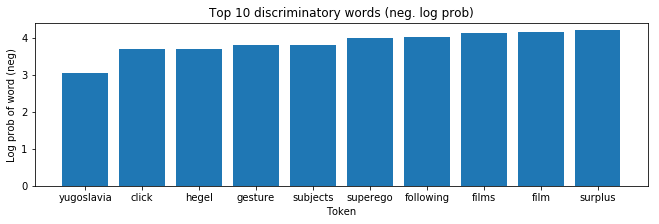

In [66]:
plt.figure(figsize=(11,3))
#plt.xlabel()
plt.bar(x=[vocab_keys[i] for i in top_args],
        height=[abs(x) for x in arg_ranks[:10]])
plt.title('Top 10 discriminatory words (neg. log prob)')
plt.ylabel('Log prob of word (neg)')
plt.xlabel('Token')
plt.show()

# Export pipeline

In [67]:
import pickle

In [68]:
pickle.dump( nb_clf, open( "nb_vect.p", "wb" ) )